In [2]:
#!pip install scikit-learn

In [3]:
#!pip install geopandas

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from ipywidgets import interact, fixed, IntSlider
from sklearn.metrics import pairwise_distances_argmin
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler
import folium
# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# Extracting Featureset and Dataset from City of Toronto Open Data

In [4]:
demograph_data = gpd.read_file('../Clean Data/demographic_data_clean_for_clustering.csv') 
#data = pd.read_csv('demographic_data_clean_for_clustering')
demograph_data.head(1000)

index       Category                                        Subcategory  \
0       0     Population                                        Total - Age   
1       1     Population                                        Total - Age   
2       2     Population                                        Total - Age   
3       3     Population                                        Total - Age   
4       4     Population                                        Total - Age   
..    ...            ...                                                ...   
995   995  Ethnocultural  Total - Ethnic or cultural origin for the popu...   
996   996  Ethnocultural  Total - Ethnic or cultural origin for the popu...   
997   997  Ethnocultural  Total - Ethnic or cultural origin for the popu...   
998   998  Ethnocultural  Total - Ethnic or cultural origin for the popu...   
999   999  Ethnocultural  Total - Ethnic or cultural origin for the popu...   

             Grouping  Toronto  Ward 1  Ward 2  Ward 3  Ward 4  Ward 5  ...  \
0         Total - Age  2761285  115120  117200  139920  104715  115675  ...   
1        0 to 4 years   123385    5755    5105    6765    4770    6045  ...   
2        5 to 9 years   128805    6160    5825    6180    5015    6060  ...   
3      10 to 14 years   131150    6585    6370    5515    5230    6360  ...   
4      15 to 19 years   133820    7085    6540    5160    4680    6390  ...   
..                ...      ...     ...     ...     ...     ...     ...  ...   
995      Cree, n.o.s.     1380      15      40      90     105      50  ...   
996            Korean    42200     500    1890    2365     835     375  ...   
997          Romanian    20010     280    1125    1080     835     210  ...   
998          Lebanese    11530     155     485     625     490     215  ...   
999           Iranian    37895     260     615    1165     425     175  ...   

    Ward 16 Ward 17 Ward 18 Ward 19 Ward 20 Ward 21 Ward 22 Ward 23 Ward 24  \
0     94335  112590  117130  108500  110095  111560  103690   94025  102755   
1      4600    4375    4525    6035    5610    5165    4000    3770    5195   
2      4755    4780    4480    6455    6230    5880    4480    4660    5890   
3      5225    5010    4425    6195    6285    5920    4815    4665    6090   
4      5225    5090    5035    5480    6425    6440    4930    4750    6030   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
995      10      15      15     150      75      50      40      10      50   
996    1380    4195   11050     815     505     525     790     225     285   
997    1480    1735    1015     870     490     385     285     155     355   
998     785     480     400     370     250    1135     465     115     195   
999    1800    6485   10370     615     490     475     645     185     305   

    Ward 25  
0    101485  
1      4365  
2      5080  
3      5590  
4      6105  
..      ...  
995      15  
996     300  
997     315  
998     300  
999     255  

[1000 rows x 30 columns]

# Perform Data Cleaning 

### Drop non-numerical columns and transpose the dataframe to define features

In [9]:
#Reset the index and turn the old index into a column before transposing
demograph_data = demograph_data.reset_index(drop = True)

#Drop disruptive columns
demograph_data = demograph_data.drop(columns=['index', 'Category', 'Subcategory'])

#Set the correct 'Grouping' column as the index
demograph_data = demograph_data.set_index('Grouping')

#Now transpose the DataFrame, which will make the rows into columns
demograph_data = demograph_data.T

#Drop the row for 'Toronto' after transposing 
tdemograph_data = demograph_data.drop(index=['Toronto'])

#Display the new DataFrame
tdemograph_data

Grouping Total - Age   0 to 4 years   5 to 9 years   10 to 14 years  \
Ward 1        115120           5755           6160             6585   
Ward 2        117200           5105           5825             6370   
Ward 3        139920           6765           6180             5515   
Ward 4        104715           4770           5015             5230   
Ward 5        115675           6045           6060             6360   
Ward 6        107355           5265           5205             5085   
Ward 7        111200           5785           6205             6780   
Ward 8        114820           5835           6205             7075   
Ward 9        104730           4665           4430             4005   
Ward 10       135400           4420           2765             2085   
Ward 11       102385           3130           2900             2950   
Ward 12       114095           4520           4345             4595   
Ward 13       116930           3720           3135             2455   
Ward 14       104555           5350           5775             5060   
Ward 15       101025           4615           5915             6770   
Ward 16        94335           4600           4755             5225   
Ward 17       112590           4375           4780             5010   
Ward 18       117130           4525           4480             4425   
Ward 19       108500           6035           6455             6195   
Ward 20       110095           5610           6230             6285   
Ward 21       111560           5165           5880             5920   
Ward 22       103690           4000           4480             4815   
Ward 23        94025           3770           4660             4665   
Ward 24       102755           5195           5890             6090   
Ward 25       101485           4365           5080             5590   

Grouping   15 to 19 years   20 to 24 years   25 to 29 years   30 to 34 years  \
Ward 1               7085             9645            10095             8125   
Ward 2               6540             6600             6820             6755   
Ward 3               5160             7040            11455            13980   
Ward 4               4680             4550             7690            10640   
Ward 5               6390             7490             8205             8450   
Ward 6               5705             7225             7840             7570   
Ward 7               7175             9380             8750             7460   
Ward 8               7220             7145             6975             7575   
Ward 9               3895             5595             9930            12345   
Ward 10              2195            10385            28800            27255   
Ward 11              3490             9715            13380            11965   
Ward 12              4485             5840            10945            12845   
Ward 13              3445            12140            17365            16335   
Ward 14              4200             4855             6620             9015   
Ward 15              6665             6035             5910             6495   
Ward 16              5225             5660             6735             6820   
Ward 17              5090             7610            10450             9870   
Ward 18              5035             8180            11500            11985   
Ward 19              5480             5295             6085             7760   
Ward 20              6425             7060             7285             7380   
Ward 21              6440             8155             8935             8055   
Ward 22              4930             6715             7605             7025   
Ward 23              4750             6835             7150             6595   
Ward 24              6030             7820             8560             7245   
Ward 25              6105             7585             7540             6140   

Grouping   35 to 39 years   40 to 44 years  ...  \
Ward 1               

In [11]:
pd.set_option('display.max_columns', None)

demograph_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26 entries, Toronto to Ward 25
Columns: 1482 entries, Total - Age to     Other government transfers %
dtypes: object(1482)
memory usage: 302.3+ KB


In [12]:
type(demograph_data)

pandas.core.frame.DataFrame

### Find all column names, then sift through to find most relevant 

In [16]:
column_names = demograph_data.columns.tolist()
#print(column_names)

In [18]:
#Check data types
tdemograph_data.dtypes

Grouping
Total - Age                                                                    object
  0 to 4 years                                                                 object
  5 to 9 years                                                                 object
  10 to 14 years                                                               object
  15 to 19 years                                                               object
                                                                                ...  
    Canada Pension Plan (CPP) and QuÃšbec Pension Plan (QPP) benefits %        object
    Old Age Security pension (OAS) and Guaranteed Income Supplement (GIS) %    object
    Employment Insurance (EI) benefits %                                       object
    Child benefits $                                                           object
    Other government transfers %                                               object
Length: 1482, dtype: object

In [20]:
#Further debugging step to look at where issues lied in data in a csv
#tdemograph_data.to_csv('C:/Users/amirv/OneDrive/Desktop/bigproject/transposed_data.csv', index=False)

In [22]:
tdemograph_data.head(25) 

Grouping Total - Age   0 to 4 years   5 to 9 years   10 to 14 years  \
Ward 1        115120           5755           6160             6585   
Ward 2        117200           5105           5825             6370   
Ward 3        139920           6765           6180             5515   
Ward 4        104715           4770           5015             5230   
Ward 5        115675           6045           6060             6360   
Ward 6        107355           5265           5205             5085   
Ward 7        111200           5785           6205             6780   
Ward 8        114820           5835           6205             7075   
Ward 9        104730           4665           4430             4005   
Ward 10       135400           4420           2765             2085   
Ward 11       102385           3130           2900             2950   
Ward 12       114095           4520           4345             4595   
Ward 13       116930           3720           3135             2455   
Ward 14       104555           5350           5775             5060   
Ward 15       101025           4615           5915             6770   
Ward 16        94335           4600           4755             5225   
Ward 17       112590           4375           4780             5010   
Ward 18       117130           4525           4480             4425   
Ward 19       108500           6035           6455             6195   
Ward 20       110095           5610           6230             6285   
Ward 21       111560           5165           5880             5920   
Ward 22       103690           4000           4480             4815   
Ward 23        94025           3770           4660             4665   
Ward 24       102755           5195           5890             6090   
Ward 25       101485           4365           5080             5590   

Grouping   15 to 19 years   20 to 24 years   25 to 29 years   30 to 34 years  \
Ward 1               7085             9645            10095             8125   
Ward 2               6540             6600             6820             6755   
Ward 3               5160             7040            11455            13980   
Ward 4               4680             4550             7690            10640   
Ward 5               6390             7490             8205             8450   
Ward 6               5705             7225             7840             7570   
Ward 7               7175             9380             8750             7460   
Ward 8               7220             7145             6975             7575   
Ward 9               3895             5595             9930            12345   
Ward 10              2195            10385            28800            27255   
Ward 11              3490             9715            13380            11965   
Ward 12              4485             5840            10945            12845   
Ward 13              3445            12140            17365            16335   
Ward 14              4200             4855             6620             9015   
Ward 15              6665             6035             5910             6495   
Ward 16              5225             5660             6735             6820   
Ward 17              5090             7610            10450             9870   
Ward 18              5035             8180            11500            11985   
Ward 19              5480             5295             6085             7760   
Ward 20              6425             7060             7285             7380   
Ward 21              6440             8155             8935             8055   
Ward 22              4930             6715             7605             7025   
Ward 23              4750             6835             7150             6595   
Ward 24              6030             7820             8560             7245   
Ward 25              6105             7585             7540             6140   

Grouping   35 to 39 years   40 to 44 years   45 to 49 years   50 to 54 y

In [23]:
#Converts values to numeric as there are columns with non-numeric values still 
tdemograph_data = tdemograph_data.apply(pd.to_numeric, errors='coerce')

print(tdemograph_data)

Grouping  Total - Age    0 to 4 years    5 to 9 years    10 to 14 years  \
Ward 1         115120            5755            6160              6585   
Ward 2         117200            5105            5825              6370   
Ward 3         139920            6765            6180              5515   
Ward 4         104715            4770            5015              5230   
Ward 5         115675            6045            6060              6360   
Ward 6         107355            5265            5205              5085   
Ward 7         111200            5785            6205              6780   
Ward 8         114820            5835            6205              7075   
Ward 9         104730            4665            4430              4005   
Ward 10        135400            4420            2765              2085   
Ward 11        102385            3130            2900              2950   
Ward 12        114095            4520            4345              4595   
Ward 13        116930    

In [24]:
#Fill empty values with 0
tdemograph_data.fillna(0)

#Drop columns with NaN values
tdemograph_data_clean = tdemograph_data.dropna(axis = 1, how = 'any')

tdemograph_data_clean.columns = tdemograph_data_clean.columns.str.strip() #Strip leading whitespace
print(tdemograph_data_clean.dtypes)

tdemograph_data_clean.head()

Grouping
Total - Age                                                                  int64
0 to 4 years                                                                 int64
5 to 9 years                                                                 int64
10 to 14 years                                                               int64
15 to 19 years                                                               int64
                                                                            ...   
Canada Pension Plan (CPP) and QuÃšbec Pension Plan (QPP) benefits %        float64
Old Age Security pension (OAS) and Guaranteed Income Supplement (GIS) %    float64
Employment Insurance (EI) benefits %                                       float64
Child benefits $                                                           float64
Other government transfers %                                               float64
Length: 1471, dtype: object


Grouping  Total - Age  0 to 4 years  5 to 9 years  10 to 14 years  \
Ward 1         115120          5755          6160            6585   
Ward 2         117200          5105          5825            6370   
Ward 3         139920          6765          6180            5515   
Ward 4         104715          4770          5015            5230   
Ward 5         115675          6045          6060            6360   

Grouping  15 to 19 years  20 to 24 years  25 to 29 years  30 to 34 years  \
Ward 1              7085            9645           10095            8125   
Ward 2              6540            6600            6820            6755   
Ward 3              5160            7040           11455           13980   
Ward 4              4680            4550            7690           10640   
Ward 5              6390            7490            8205            8450   

Grouping  35 to 39 years  40 to 44 years  45 to 49 years  50 to 54 years  \
Ward 1              7265            6905            7035            7515   
Ward 2              7395            7045            7135            8380   
Ward 3             12460           10305            9380            9215   
Ward 4              9900            8465            7925            7345   
Ward 5              8400            7845            7325            7970   

Grouping  55 to 59 years  60 to 64 years  65 to 69 years  70 to 74 years  \
Ward 1              7925            7070            5495            4745   
Ward 2              9530            8675            7165            6020   
Ward 3              9705            9140            7315            6365   
Ward 4              7010            6260            5100            4230   
Ward 5              8875            7860            5900            4470   

Grouping  75 to 79 years  80 to 84 years  85 to 89 years  90 years and over  \
Ward 1              3140            2390            1435                745   
Ward 2              4060            3575            2555               1650   
Ward 3              4065            3000            1830               1045   
Ward 4              2500            1715            1105                575   
Ward 5              3035            2295            1665               1035   

Grouping  Median age  \
Ward 1          38.0   
Ward 2          45.2   
Ward 3          40.8   
Ward 4          40.0   
Ward 5          40.4   

Grouping  Total - Occupied private dwellings by structural type of dwelling - 25% sample data  \
Ward 1                                                38135                                     
Ward 2                                                45345                                     
Ward 3                                                65575                                     
Ward 4                                                49445                                     
Ward 5                                                45055                                     

Grouping  Single-detached house  Semi-detached house  Row house  \
Ward 1                    11270                 1425       3645   
Ward 2                    21860                  875       2005   
Ward 3                    18585                 1365       2340   
Ward 4                     8855                 4215       1175   
Ward 5                    13190                 3315       1265   

Grouping  Apartment or flat in a duplex  \
Ward 1                             3790   
Ward 2                              785   
Ward 3                             1500   
Ward 4                             2120   
Ward 5                             1845   

Grouping  Apartment in a building that has fewer than five storeys  \
Ward 1                                                 2015          
Ward 2                                                 1925          
Ward 3                                                11100          
Ward 4                                                14040          

In [25]:
selected_columns = ['10 to 14 years', '15 to 19 years', '20 to 24 years', '25 to 29 years', '30 to 34 years', 
                    '35 to 39 years', '40 to 44 years', '45 to 49 years', '50 to 54 years', 
                    '55 to 59 years', '60 to 64 years', '65 to 69 years', '70 to 74 years', 
                    '75 to 79 years', '80 to 84 years', '85 to 89 years', '90 years and over', 
                    '1960 or before', '1961 to 1980', '1981 to 1990', '1991 to 2000', '2001 to 2005', 
                    '2006 to 2010', '2011 to 2015', '2016 to 2021', 'Non-immigrants', 'Immigrants', 
                    'No certificate, diploma or degree', 'High (secondary) school diploma or equivalency certificate', 
                    'Postsecondary certificate, diploma or degree',  'Employed', 'Unemployed', 
                    'Under $5,000', '$5,000 to $9,999', '$10,000 to $14,999', '$15,000 to $19,999', '$20,000 to $24,999', 
                    '$25,000 to $29,999', '$30,000 to $34,999', '$35,000 to $39,999', '$40,000 to $44,999', '$45,000 to $49,999', 
                    '$50,000 to $59,999', '$60,000 to $69,999', '$70,000 to $79,999', '$80,000 to $89,999', '$90,000 to $99,999', 
                    '$100,000 to $124,999', '$125,000 to $149,999', '$150,000 to $199,999', '$200,000 and over', 
                    'Average total income of households in 2020 ($)',  
                    'Total visible minority population']

tdemograph_data_clean = tdemograph_data_clean[selected_columns] 

In [26]:
tdemograph_data_clean #Cleaning df to have less columns

Grouping  10 to 14 years  15 to 19 years  20 to 24 years  25 to 29 years  \
Ward 1              6585            7085            9645           10095   
Ward 2              6370            6540            6600            6820   
Ward 3              5515            5160            7040           11455   
Ward 4              5230            4680            4550            7690   
Ward 5              6360            6390            7490            8205   
Ward 6              5085            5705            7225            7840   
Ward 7              6780            7175            9380            8750   
Ward 8              7075            7220            7145            6975   
Ward 9              4005            3895            5595            9930   
Ward 10             2085            2195           10385           28800   
Ward 11             2950            3490            9715           13380   
Ward 12             4595            4485            5840           10945   
Ward 13             2455            3445           12140           17365   
Ward 14             5060            4200            4855            6620   
Ward 15             6770            6665            6035            5910   
Ward 16             5225            5225            5660            6735   
Ward 17             5010            5090            7610           10450   
Ward 18             4425            5035            8180           11500   
Ward 19             6195            5480            5295            6085   
Ward 20             6285            6425            7060            7285   
Ward 21             5920            6440            8155            8935   
Ward 22             4815            4930            6715            7605   
Ward 23             4665            4750            6835            7150   
Ward 24             6090            6030            7820            8560   
Ward 25             5590            6105            7585            7540   

Grouping  30 to 34 years  35 to 39 years  40 to 44 years  45 to 49 years  \
Ward 1              8125            7265            6905            7035   
Ward 2              6755            7395            7045            7135   
Ward 3             13980           12460           10305            9380   
Ward 4             10640            9900            8465            7925   
Ward 5              8450            8400            7845            7325   
Ward 6              7570            7560            7710            7305   
Ward 7              7460            7445            7180            6605   
Ward 8              7575            7580            7910            7955   
Ward 9             12345           10760            8415            7045   
Ward 10            27255           15870            9345            6630   
Ward 11            11965            8315            5805            5405   
Ward 12            12845           10070            7505            7130   
Ward 13            16335           11390            7635            6535   
Ward 14             9015            9515            8915            7935   
Ward 15             6495            6380            6565            7075   
Ward 16             6820            6280            6250            6095   
Ward 17             9870            8405            6975            6740   
Ward 18            11985            9520            7880            7455   
Ward 19             7760            8765            8915            8010   
Ward 20             7380            7645            7500            7370   
Ward 21             8055            7455            6685            6905   
Ward 22             7025            6305            5655            6010   
Ward 23             6595            5645            5185            5350   
Ward 24             7245            6535            6410            6200   
Ward 25             6140            5980            5660            6200   

Grouping  50 to 54 years  55 to 59 years  60 t

### Remove duplicate code

In [28]:
tdemograph_data_clean = tdemograph_data_clean.loc[:, ~tdemograph_data_clean.columns.duplicated()]
tdemograph_data_clean

Grouping  10 to 14 years  15 to 19 years  20 to 24 years  25 to 29 years  \
Ward 1              6585            7085            9645           10095   
Ward 2              6370            6540            6600            6820   
Ward 3              5515            5160            7040           11455   
Ward 4              5230            4680            4550            7690   
Ward 5              6360            6390            7490            8205   
Ward 6              5085            5705            7225            7840   
Ward 7              6780            7175            9380            8750   
Ward 8              7075            7220            7145            6975   
Ward 9              4005            3895            5595            9930   
Ward 10             2085            2195           10385           28800   
Ward 11             2950            3490            9715           13380   
Ward 12             4595            4485            5840           10945   
Ward 13             2455            3445           12140           17365   
Ward 14             5060            4200            4855            6620   
Ward 15             6770            6665            6035            5910   
Ward 16             5225            5225            5660            6735   
Ward 17             5010            5090            7610           10450   
Ward 18             4425            5035            8180           11500   
Ward 19             6195            5480            5295            6085   
Ward 20             6285            6425            7060            7285   
Ward 21             5920            6440            8155            8935   
Ward 22             4815            4930            6715            7605   
Ward 23             4665            4750            6835            7150   
Ward 24             6090            6030            7820            8560   
Ward 25             5590            6105            7585            7540   

Grouping  30 to 34 years  35 to 39 years  40 to 44 years  45 to 49 years  \
Ward 1              8125            7265            6905            7035   
Ward 2              6755            7395            7045            7135   
Ward 3             13980           12460           10305            9380   
Ward 4             10640            9900            8465            7925   
Ward 5              8450            8400            7845            7325   
Ward 6              7570            7560            7710            7305   
Ward 7              7460            7445            7180            6605   
Ward 8              7575            7580            7910            7955   
Ward 9             12345           10760            8415            7045   
Ward 10            27255           15870            9345            6630   
Ward 11            11965            8315            5805            5405   
Ward 12            12845           10070            7505            7130   
Ward 13            16335           11390            7635            6535   
Ward 14             9015            9515            8915            7935   
Ward 15             6495            6380            6565            7075   
Ward 16             6820            6280            6250            6095   
Ward 17             9870            8405            6975            6740   
Ward 18            11985            9520            7880            7455   
Ward 19             7760            8765            8915            8010   
Ward 20             7380            7645            7500            7370   
Ward 21             8055            7455            6685            6905   
Ward 22             7025            6305            5655            6010   
Ward 23             6595            5645            5185            5350   
Ward 24             7245            6535            6410            6200   
Ward 25             6140            5980            5660            6200   

Grouping  50 to 54 years  55 to 59 years  60 t

In [29]:
tdemograph_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, Ward 1 to Ward 25
Data columns (total 53 columns):
 #   Column                                                      Non-Null Count  Dtype
---  ------                                                      --------------  -----
 0   10 to 14 years                                              25 non-null     int64
 1   15 to 19 years                                              25 non-null     int64
 2   20 to 24 years                                              25 non-null     int64
 3   25 to 29 years                                              25 non-null     int64
 4   30 to 34 years                                              25 non-null     int64
 5   35 to 39 years                                              25 non-null     int64
 6   40 to 44 years                                              25 non-null     int64
 7   45 to 49 years                                              25 non-null     int64
 8   50 to 54 years   

### Import collision data to use in conjunction with demographic data


In [33]:
rough_collision_data = gpd.read_file('../Clean Data/collision_ward_data.geojson') 
#do strip for column labels 
#do .describe()
rough_collision_data.head()

DATE  HOUR DAY OF WEEK  MONTH  YEAR BICYCLE  LONGITUDE   LATITUDE  \
0 2014-01-02    18    Thursday      1  2014     YES -79.380272  43.648644   
1 2014-01-03    11      Friday      1  2014     YES -79.399845  43.652539   
2 2014-01-09    13    Thursday      1  2014     YES -79.405167  43.656966   
3 2014-01-09     5    Thursday      1  2014     YES -79.480613  43.665578   
4 2014-01-12    22      Sunday      1  2014     YES -79.377892  43.649143   

                TIME OF DAY WARD NUMBER            WARD NAME  \
0     Evening (5 PM - 9 PM)          13       Toronto Centre   
1    Morning (5 AM - 12 PM)          10    Spadina-Fort York   
2  Afternoon (12 PM - 5 PM)          11  University-Rosedale   
3    Morning (5 AM - 12 PM)          04   Parkdale-High Park   
4       Night (9 PM - 5 AM)          13       Toronto Centre   

           WARD DISTRICT                    geometry  
0  Toronto and East York  POINT (-79.38027 43.64864)  
1  Toronto and East York  POINT (-79.39984 43.65254)  
2  Toronto and East York  POINT (-79.40517 43.65697)  
3  Toronto and East York  POINT (-79.48061 43.66558)  
4  Toronto and East York  POINT (-79.37789 43.64914)

In [34]:
rough_collision_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10402 entries, 0 to 10401
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATE           10402 non-null  datetime64[ms]
 1   HOUR           10402 non-null  int32         
 2   DAY OF WEEK    10402 non-null  object        
 3   MONTH          10402 non-null  int32         
 4   YEAR           10402 non-null  int32         
 5   BICYCLE        10402 non-null  object        
 6   LONGITUDE      10402 non-null  float64       
 7   LATITUDE       10402 non-null  float64       
 8   TIME OF DAY    10402 non-null  object        
 9   WARD NUMBER    10375 non-null  object        
 10  WARD NAME      10375 non-null  object        
 11  WARD DISTRICT  10375 non-null  object        
 12  geometry       10402 non-null  geometry      
dtypes: datetime64[ms](1), float64(2), geometry(1), int32(3), object(6)
memory usage: 934.7+ KB


In [37]:
print(rough_collision_data.columns)

Index(['DATE', 'HOUR', 'DAY OF WEEK', 'MONTH', 'YEAR', 'BICYCLE', 'LONGITUDE',
       'LATITUDE', 'TIME OF DAY', 'WARD NUMBER', 'WARD NAME', 'WARD DISTRICT',
       'geometry'],
      dtype='object')


In [41]:
geojson_path = "../Clean Data/wards_data.geojson"
# Load the shapefile
wards_data = gpd.read_file(geojson_path)
wards_data = wards_data.to_crs("EPSG:32617")
#wards_data = wards_data.rename(columns = {'WARD NUMBER': 'Ward #'})
wards_data['Area (sqkm)'] = wards_data['geometry'].area / 1000000
#wards_data[['WARD NUMBER', 'Area (sqm)']].head()
wards_data

WARD NUMBER                 WARD NAME          WARD DISTRICT  \
0           01           Etobicoke North         Etobicoke York   
1           02          Etobicoke Centre         Etobicoke York   
2           03       Etobicoke-Lakeshore         Etobicoke York   
3           04        Parkdale-High Park  Toronto and East York   
4           05         York South-Weston         Etobicoke York   
5           06               York Centre             North York   
6           07  Humber River-Black Creek         Etobicoke York   
7           08         Eglinton-Lawrence             North York   
8           09                 Davenport  Toronto and East York   
9           10         Spadina-Fort York  Toronto and East York   
10          11       University-Rosedale  Toronto and East York   
11          12        Toronto-St. Paul's  Toronto and East York   
12          13            Toronto Centre  Toronto and East York   
13          14          Toronto-Danforth  Toronto and East York   
14          15           Don Valley West             North York   
15          16           Don Valley East             North York   
16          17          Don Valley North             North York   
17          18                Willowdale             North York   
18          19         Beaches-East York  Toronto and East York   
19          20     Scarborough Southwest            Scarborough   
20          21        Scarborough Centre            Scarborough   
21          22     Scarborough-Agincourt            Scarborough   
22          23         Scarborough North            Scarborough   
23          24     Scarborough-Guildwood            Scarborough   
24          25    Scarborough-Rouge Park            Scarborough   

                                             geometry  Area (sqkm)  
0   POLYGON ((614361.91 4846443.252, 614376.274 48...    48.352261  
1   POLYGON ((618769.981 4839786.381, 618770.007 4...    37.339753  
2   POLYGON ((621184.054 4834315.989, 621213.577 4...    40.012427  
3   POLYGON ((623660.782 4836061.188, 623724.263 4...    15.324931  
4   POLYGON ((623361.036 4840391.392, 623364.743 4...    24.973564  
5   POLYGON ((625573.374 4846572.683, 625598.943 4...    35.352672  
6   POLYGON ((621544.221 4846305.883, 621553.399 4...    30.694206  
7   POLYGON ((623717.321 4838857.467, 623714.06 48...    22.657718  
8   POLYGON ((625237.946 4838123.486, 625325.017 4...    12.092764  
9   POLYGON ((630376.268 4834749.958, 630424.532 4...    18.698985  
10  POLYGON ((629746.875 4838759.538, 629744.137 4...    13.594705  
11  POLYGON ((629786.119 4838874.966, 629784.314 4...    13.119079  
12  POLYGON ((630840.804 4836850.69, 630851.372 48...     5.861979  
13  POLYGON ((634398.174 4840215.916, 634406.365 4...    21.798052  
14  POLYGON ((632750.244 4841612.302, 632775.986 4...    30.291445  
15  POLYGON ((635375.169 4841661.719, 635371.243 4...    22.961197  
16  POLYGON ((629822.356 4846848.965, 629818.752 4...    24.416752  
17  POLYGON ((629226.165 4846639.841, 629217.026 4...    19.758824  
18  POLYGON ((637070.351 4841601.668, 637080.257 4...    16.801755  
19  POLYGON ((638543.236 4837419.307, 638530.477 4...    28.187886  
20  POLYGON ((640873.726 4847531.026, 640941.13 48...    28.201836  
21  POLYGON ((635490.727 4847524.358, 635479.721 4...    21.395977  
22  POLYGON ((642648.265 4855575.651, 642682.97 48...    30.433948  
23  POLYGON ((646417.864 4846423.455, 646477.766 4...    26.114730  
24  POLYGON ((647758.328 4855443.039, 647761.138 4...    54.085523

In [42]:
wards_data = wards_data[['WARD NUMBER', 'geometry', 'Area (sqkm)']] 
rough_collision_data = rough_collision_data.drop(columns = ['geometry'])
collision_data = rough_collision_data.merge(wards_data, on = 'WARD NUMBER', how = 'left')
collision_data

DATE  HOUR DAY OF WEEK  MONTH  YEAR BICYCLE  LONGITUDE   LATITUDE  \
0     2014-01-02    18    Thursday      1  2014     YES -79.380272  43.648644   
1     2014-01-03    11      Friday      1  2014     YES -79.399845  43.652539   
2     2014-01-09    13    Thursday      1  2014     YES -79.405167  43.656966   
3     2014-01-09     5    Thursday      1  2014     YES -79.480613  43.665578   
4     2014-01-12    22      Sunday      1  2014     YES -79.377892  43.649143   
...          ...   ...         ...    ...   ...     ...        ...        ...   
10397 2024-09-30    18      Monday      9  2024     YES -79.423258  43.662508   
10398 2024-09-30    10      Monday      9  2024     YES -79.409940  43.645990   
10399 2024-09-30     8      Monday      9  2024     YES -79.297271  43.825952   
10400 2024-09-30    14      Monday      9  2024     YES -79.378334  43.666282   
10401 2024-09-30    20      Monday      9  2024     YES -79.375753  43.669662   

                    TIME OF DAY WARD NUMBER            WARD NAME  \
0         Evening (5 PM - 9 PM)          13       Toronto Centre   
1        Morning (5 AM - 12 PM)          10    Spadina-Fort York   
2      Afternoon (12 PM - 5 PM)          11  University-Rosedale   
3        Morning (5 AM - 12 PM)          04   Parkdale-High Park   
4           Night (9 PM - 5 AM)          13       Toronto Centre   
...                         ...         ...                  ...   
10397     Evening (5 PM - 9 PM)          11  University-Rosedale   
10398    Morning (5 AM - 12 PM)          10    Spadina-Fort York   
10399    Morning (5 AM - 12 PM)          23    Scarborough North   
10400  Afternoon (12 PM - 5 PM)          13       Toronto Centre   
10401     Evening (5 PM - 9 PM)          13       Toronto Centre   

               WARD DISTRICT  \
0      Toronto and East York   
1      Toronto and East York   
2      Toronto and East York   
3      Toronto and East York   
4      Toronto and East York   
...                      ...   
10397  Toronto and East York   
10398  Toronto and East York   
10399            Scarborough   
10400  Toronto and East York   
10401  Toronto and East York   

                                                geometry  Area (sqkm)  
0      POLYGON ((630840.804 4836850.69, 630851.372 48...     5.861979  
1      POLYGON ((630376.268 4834749.958, 630424.532 4...    18.698985  
2      POLYGON ((629746.875 4838759.538, 629744.137 4...    13.594705  
3      POLYGON ((623660.782 4836061.188, 623724.263 4...    15.324931  
4      POLYGON ((630840.804 4836850.69, 630851.372 48...     5.861979  
...                                                  ...          ...  
10397  POLYGON ((629746.875 4838759.538, 629744.137 4...    13.594705  
10398  POLYGON ((630376.268 4834749.958, 630424.532 4...    18.698985  
10399  POLYGON ((642648.265 4855575.651, 642682.97 48...    30.433948  
10400  POLYGON ((630840.804 4836850.69, 630851.372 48...     5.861979  
10401  POLYGON ((630840.804 4836850.69, 630851.372 48...     5.861979  

[10402 rows x 14 columns]

In [46]:
#Perform further data cleaning and rename columns

#collision_data = collision_data.to_crs(epsg = 3395)  #WGS 84 (meters)

collision_data['BICYCLE'] = collision_data['BICYCLE'].str.lower()
collision_data['BICYCLE'] = collision_data['BICYCLE'].map({'yes': 1, 'no': 0})
bike_collision = collision_data[collision_data['BICYCLE'] == 1]

ward_collision = (bike_collision.groupby('WARD NUMBER', as_index = False).agg(
                                        {'BICYCLE': 'sum',               #Total number of collisions for a ward
                                         'LATITUDE': 'mean',             #Average latitude (future use)
                                         'LONGITUDE': 'mean',            #Average longitude (future use)
                                         'WARD NAME': 'first',           #Ward name
                                         'Area (sqkm)': 'first',      #Ward area in square meters
                                        }).rename(columns={'BICYCLE': 'Bike Collisions', 
                                                           'WARD NUMBER': 'Ward #', 
                                                           'LATITUDE': 'Avg Latitude', 
                                                           'LONGITUDE': 'Avg Longitude', 
                                                           'WARD NAME': 'Ward Name'}))

cols = list(ward_collision.columns)
#Rearrange the columns for clarity 
cols.remove('Ward Name')  #Remove 'Ward Name' temporarily
cols.insert(cols.index('Ward #') + 1, 'Ward Name')
ward_collision = ward_collision[cols]
ward_collision.head()

Ward #            Ward Name  Bike Collisions  Avg Latitude  Avg Longitude  \
0     01      Etobicoke North              216     43.727229     -79.583182   
1     02     Etobicoke Centre              217     43.667718     -79.550024   
2     03  Etobicoke-Lakeshore              376     43.620498     -79.514390   
3     04   Parkdale-High Park              550     43.650676     -79.458589   
4     05    York South-Weston              268     43.689563     -79.489267   

   Area (sqkm)  
0    48.352261  
1    37.339753  
2    40.012427  
3    15.324931  
4    24.973564

In [47]:
ward_collision.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ward #           25 non-null     object 
 1   Ward Name        25 non-null     object 
 2   Bike Collisions  25 non-null     int64  
 3   Avg Latitude     25 non-null     float64
 4   Avg Longitude    25 non-null     float64
 5   Area (sqkm)      25 non-null     float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.3+ KB


In [48]:
#Combining or binning data to get better descriptors of data that follow traditional socioeconomic categories of lower, middle, and higher classes
tdemograph_data_clean['Teenager'] = (tdemograph_data_clean.pop('15 to 19 years') +  tdemograph_data_clean.pop('10 to 14 years'))

tdemograph_data_clean['Young Adult'] = (
    tdemograph_data_clean.pop('20 to 24 years') +
    tdemograph_data_clean.pop('25 to 29 years')
)

tdemograph_data_clean['Middle Aged'] = (
    tdemograph_data_clean.pop('30 to 34 years') +
    tdemograph_data_clean.pop('35 to 39 years') +
    tdemograph_data_clean.pop('40 to 44 years') +
    tdemograph_data_clean.pop('45 to 49 years')
)

tdemograph_data_clean['Senior'] = (
    tdemograph_data_clean.pop('50 to 54 years') +
    tdemograph_data_clean.pop('55 to 59 years') +
    tdemograph_data_clean.pop('60 to 64 years') +
    tdemograph_data_clean.pop('65 to 69 years') +
    tdemograph_data_clean.pop('70 to 74 years') +
    tdemograph_data_clean.pop('75 to 79 years') +
    tdemograph_data_clean.pop('80 to 84 years') +
    tdemograph_data_clean.pop('85 to 89 years') +
    tdemograph_data_clean.pop('90 years and over')
)

tdemograph_data_clean['Constructed from 2000 or before'] = (
    tdemograph_data_clean.pop('1960 or before') +
    tdemograph_data_clean.pop('1961 to 1980') +
    tdemograph_data_clean.pop('1981 to 1990') +
    tdemograph_data_clean.pop('1991 to 2000')
)

tdemograph_data_clean['Constructed from 2000 or after'] = (
    tdemograph_data_clean.pop('2001 to 2005') +
    tdemograph_data_clean.pop('2006 to 2010') +
    tdemograph_data_clean.pop('2011 to 2015') +
    tdemograph_data_clean.pop('2016 to 2021')
)

#Above poverty line to $35000 (minimum wage)
tdemograph_data_clean['Lower Class'] = (
    tdemograph_data_clean.pop('Under $5,000') +
    tdemograph_data_clean.pop('$5,000 to $9,999') +
    tdemograph_data_clean.pop('$10,000 to $14,999') +
    tdemograph_data_clean.pop('$15,000 to $19,999') +
    tdemograph_data_clean.pop('$20,000 to $24,999') +
    tdemograph_data_clean.pop('$25,000 to $29,999') +
    tdemograph_data_clean.pop('$30,000 to $34,999')
)

#Middle class
tdemograph_data_clean['Middle Class'] = (
    tdemograph_data_clean.pop('$35,000 to $39,999') +
    tdemograph_data_clean.pop('$40,000 to $44,999') +
    tdemograph_data_clean.pop('$45,000 to $49,999') +
    tdemograph_data_clean.pop('$50,000 to $59,999') +
    tdemograph_data_clean.pop('$60,000 to $69,999') +
    tdemograph_data_clean.pop('$70,000 to $79,999') +
    tdemograph_data_clean.pop('$80,000 to $89,999') +
    tdemograph_data_clean.pop('$90,000 to $99,999') +
    tdemograph_data_clean.pop('$100,000 to $124,999') +
    tdemograph_data_clean.pop('$125,000 to $149,999') + 
    tdemograph_data_clean.pop('$150,000 to $199,999')
)

#High class is $200,000 and over

tdemograph_data_clean['High Class'] = (tdemograph_data_clean.pop('$200,000 and over'))

#https://www.theglobeandmail.com/investing/markets/markets-news/Motley%20Fool/19986251/does-your-income-make-you-upper-class-middle-class-or-lower-class/

In [51]:
tdemograph_data_clean.head(26)

Grouping  Non-immigrants  Immigrants  No certificate, diploma or degree  \
Ward 1             43640       64675                              21870   
Ward 2             66315       48485                              12955   
Ward 3             80045       54670                              12970   
Ward 4             69575       32400                               9500   
Ward 5             52820       58205                              25160   
Ward 6             43790       59525                              14700   
Ward 7             40905       62700                              25665   
Ward 8             65435       44725                              12045   
Ward 9             60865       39645                              18865   
Ward 10            70400       53910                               6555   
Ward 11            59515       34755                               7245   
Ward 12            67205       40430                               8230   
Ward 13            56170       48730                               8330   
Ward 14            70475       31915                              12495   
Ward 15            55720       41420                               8135   
Ward 16            39635       50390                              11670   
Ward 17            34110       68280                               9570   
Ward 18            35140       70535                               7865   
Ward 19            71210       34420                              11445   
Ward 20            55395       50370                              15480   
Ward 21            43560       61670                              16805   
Ward 22            31595       66065                              16795   
Ward 23            28855       60740                              17555   
Ward 24            42060       54840                              14775   
Ward 25            45475       52660                              12825   

Grouping  High (secondary) school diploma or equivalency certificate  \
Ward 1                                                28780            
Ward 2                                                25030            
Ward 3                                                25415            
Ward 4                                                17360            
Ward 5                                                29000            
Ward 6                                                23755            
Ward 7                                                28780            
Ward 8                                                20870            
Ward 9                                                19875            
Ward 10                                               17105            
Ward 11                                               16045            
Ward 12                                               17585            
Ward 13                                               20970            
Ward 14                                               18125            
Ward 15                                               16200            
Ward 16                                               20155            
Ward 17                                               20050            
Ward 18                                               20435            
Ward 19                                               20145            
Ward 20                                               25460            
Ward 21                                               27495            
Ward 22                                               24195            
Ward 23                                               23610            
Ward 24                                               24090            
Ward 25                                               25060            

Grouping  Postsecondary certificate, diploma or degree  Employed  Unemployed  \
Ward 1                                           45965     47840        9430   
Ward 2          

In [55]:
#Debugging cell 
tdemograph_data_clean = tdemograph_data_clean.select_dtypes(include=np.number)

if tdemograph_data_clean.isnull().values.any():
    tdemograph_data_clean = tdemograph_data_clean.fillna(0)

In [58]:
#Applying min max scaling to control feature influence
#Use minmax scaler to have values from 0 to 1 only
scaler = MinMaxScaler()

#Apply scaling to columns 

tdemograph_data_clean_scaled = pd.DataFrame(scaler.fit_transform(tdemograph_data_clean), 
                               columns = tdemograph_data_clean.columns)

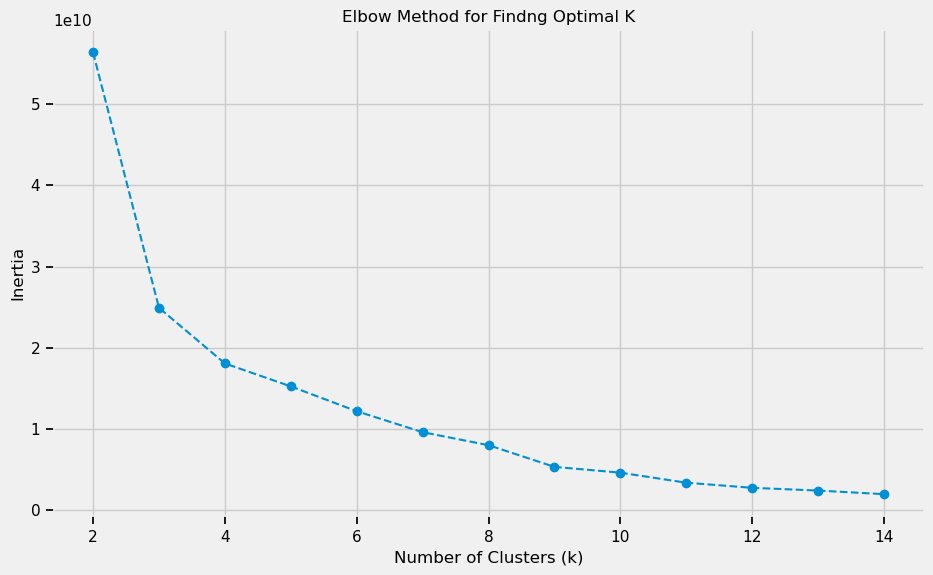

In [60]:
#Use the Elbow method to find number of clusters needed
inertia = []
k_range = range(2, 15)  #Test for different number of clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tdemograph_data_clean)
    inertia.append(kmeans.inertia_)

#Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title("Elbow Method for Findng Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

In [61]:
tdemograph_data_clean_scaled.head(26)

Grouping  Non-immigrants  Immigrants  No certificate, diploma or degree  \
0               0.288826    0.848265                           0.801413   
1               0.731784    0.429052                           0.334903   
2               1.000000    0.589202                           0.335688   
3               0.795468    0.012558                           0.154108   
4               0.468158    0.680735                           0.973574   
5               0.291756    0.714915                           0.426217   
6               0.235398    0.797126                           1.000000   
7               0.714593    0.331693                           0.287284   
8               0.625317    0.200155                           0.644165   
9               0.811584    0.569524                           0.000000   
10              0.598945    0.073537                           0.036107   
11              0.749170    0.220482                           0.087650   
12              0.533600    0.435396                           0.092883   
13              0.813049    0.000000                           0.310832   
14              0.524810    0.246116                           0.082679   
15              0.210588    0.478379                           0.267661   
16              0.102657    0.941611                           0.157771   
17              0.122778    1.000000                           0.068550   
18              0.827408    0.064863                           0.255887   
19              0.518461    0.477861                           0.467033   
20              0.287263    0.770456                           0.536368   
21              0.053526    0.884257                           0.535845   
22              0.000000    0.746375                           0.575615   
23              0.257961    0.593604                           0.430141   
24              0.324673    0.537157                           0.328100   

Grouping  High (secondary) school diploma or equivalency certificate  \
0                                                  0.983018            
1                                                  0.693555            
2                                                  0.723273            
3                                                  0.101505            
4                                                  1.000000            
5                                                  0.595137            
6                                                  0.983018            
7                                                  0.372443            
8                                                  0.295639            
9                                                  0.081822            
10                                                 0.000000            
11                                                 0.118873            
12                                                 0.380162            
13                                                 0.160556            
14                                                 0.011964            
15                                                 0.317252            
16                                                 0.309147            
17                                                 0.338865            
18                                                 0.316480            
19                                                 0.726746            
20                                                 0.883829            
21                                                 0.629101            
22                                                 0.583944            
23                                                 0.620996            
24                                                 0.695870            

Grouping  Postsecondary certificate, diploma or degree  Employed  Unemployed  \
0                                             0.123682  0.186720       0.617   
1               

Text(0.5, 1.0, 'Correlation Matrix of Features')

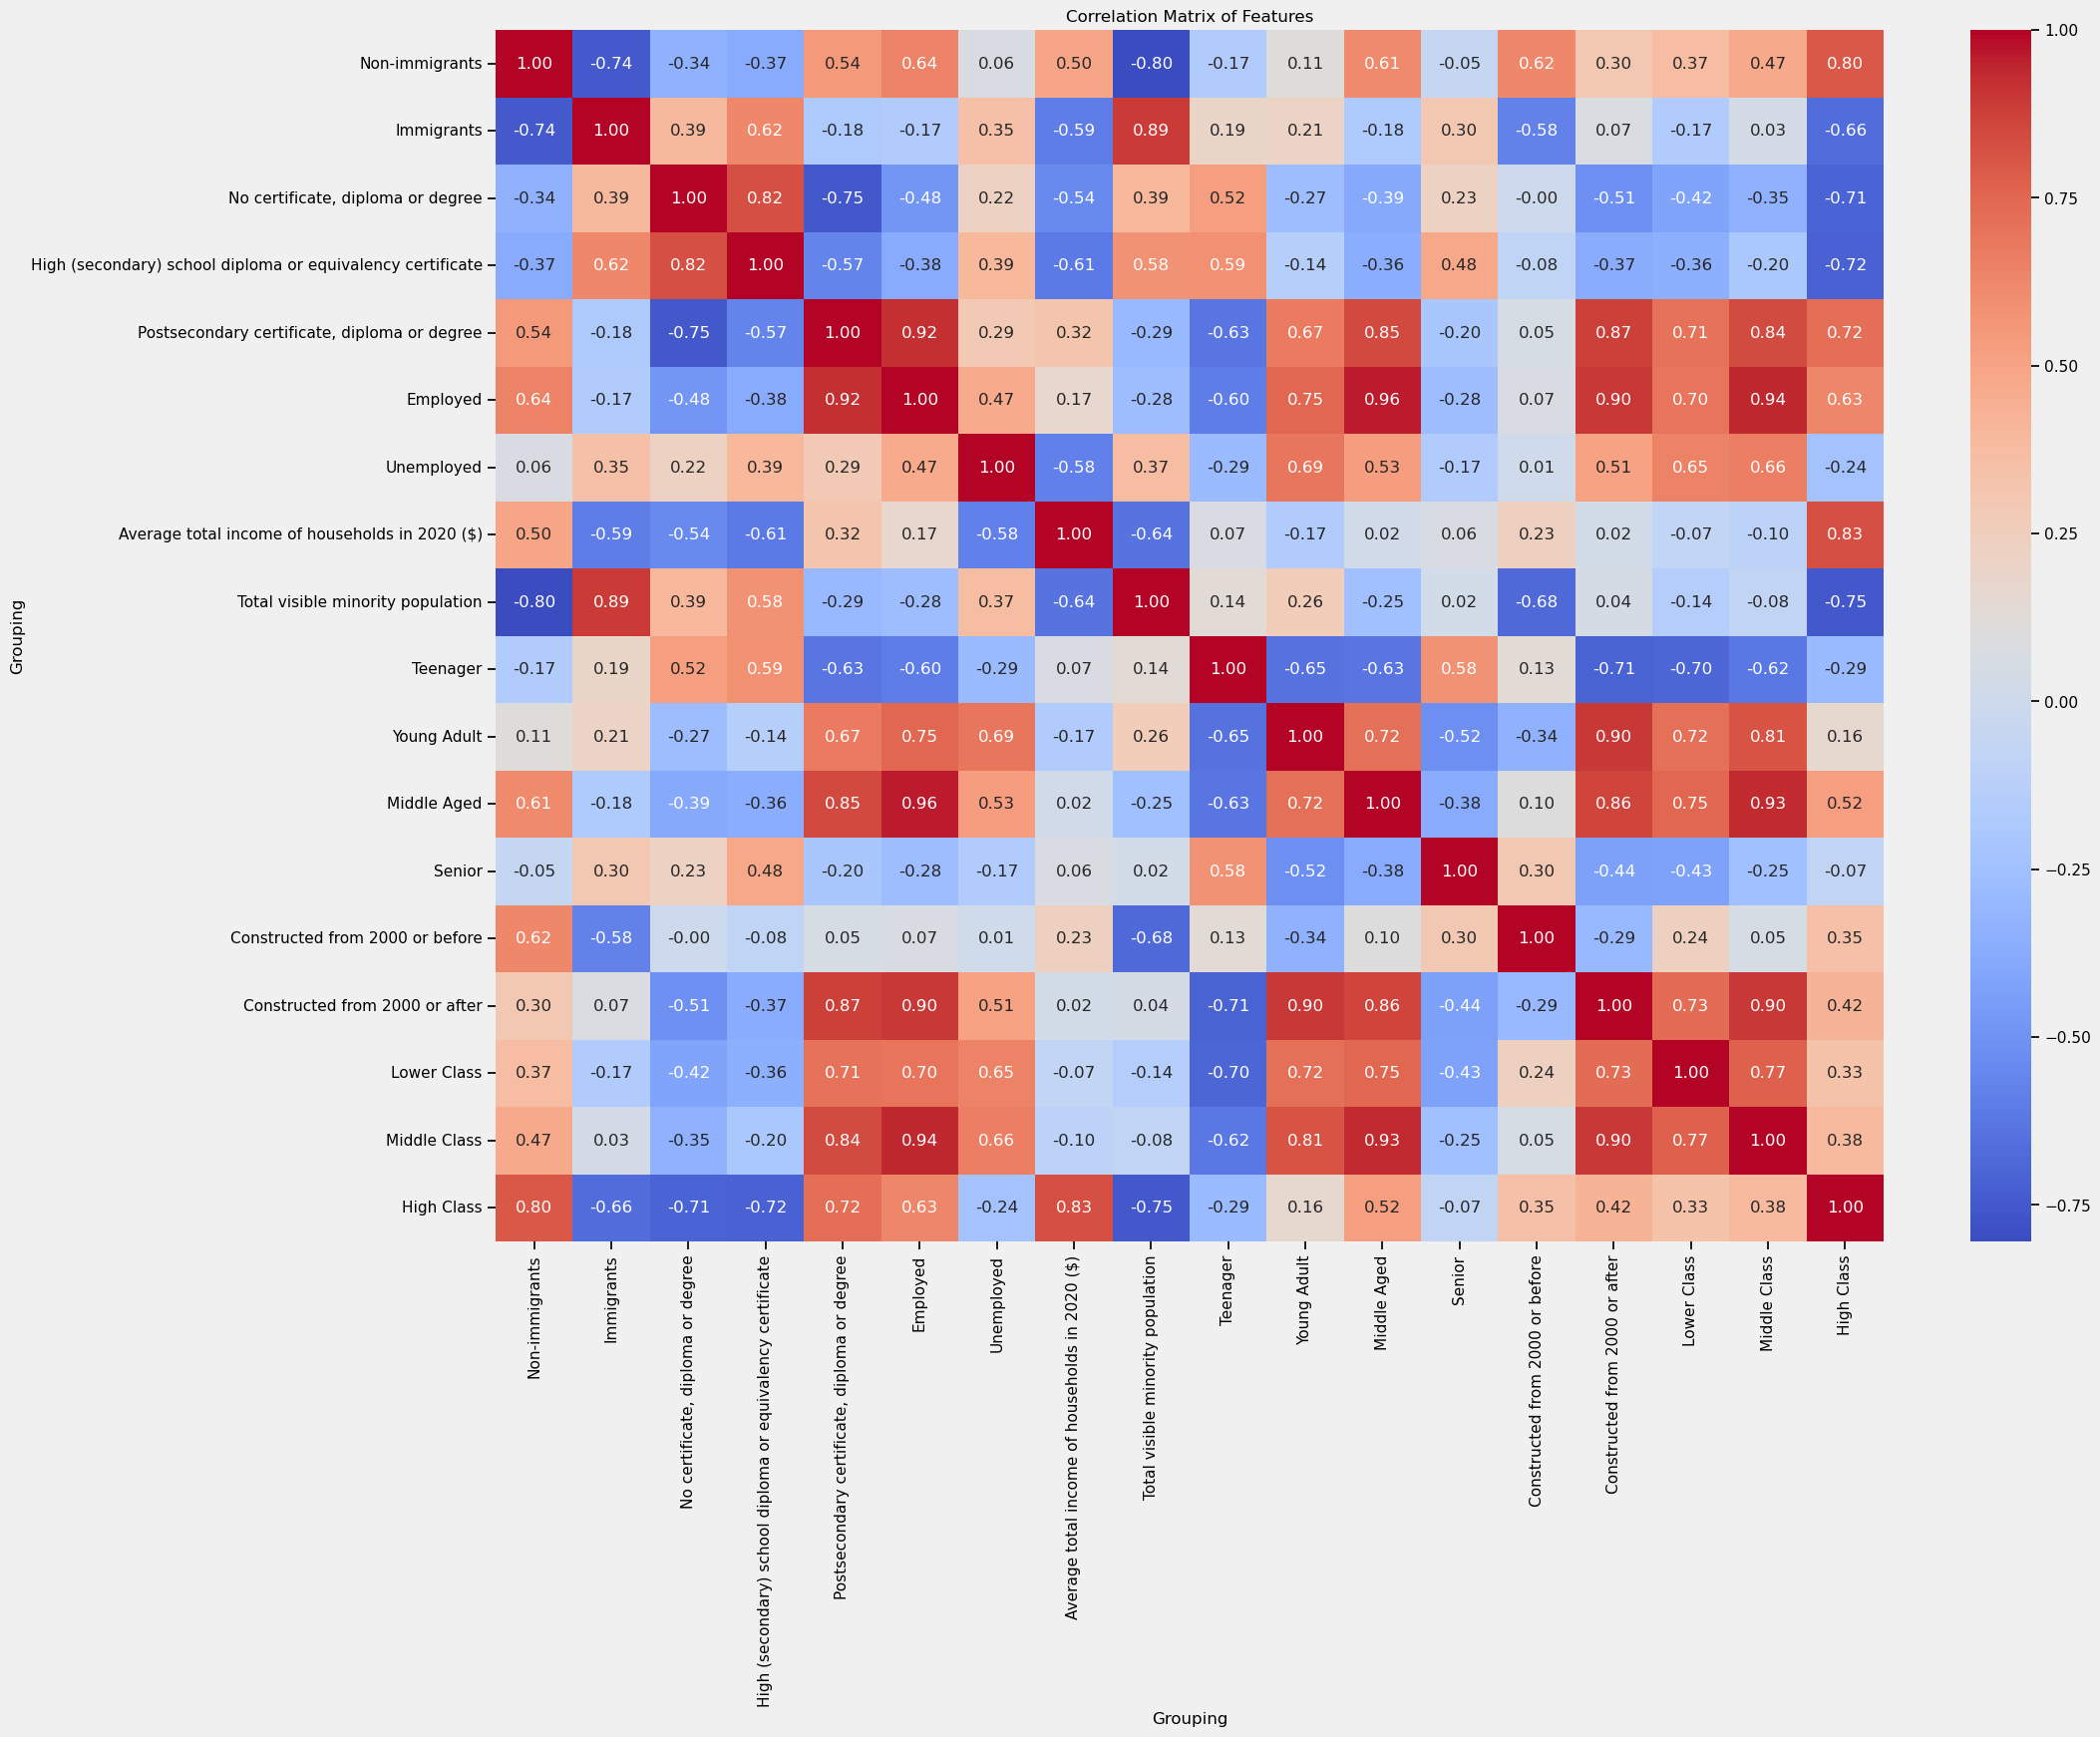

In [62]:
correlation_matrix = tdemograph_data_clean_scaled.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(20,15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Features")

In [63]:
#Choose an optimal number of clusters based on the Elbow Curve
optimal_k = 5  # Adjust based on the elbow curve
kmeans = KMeans(n_clusters = optimal_k, random_state = 42, n_init = 100)
tdemograph_data_clean_scaled['Cluster'] = kmeans.fit_predict(tdemograph_data_clean_scaled)
tdemograph_data_clean_scaled['Cluster'] = tdemograph_data_clean_scaled['Cluster'].astype(int)


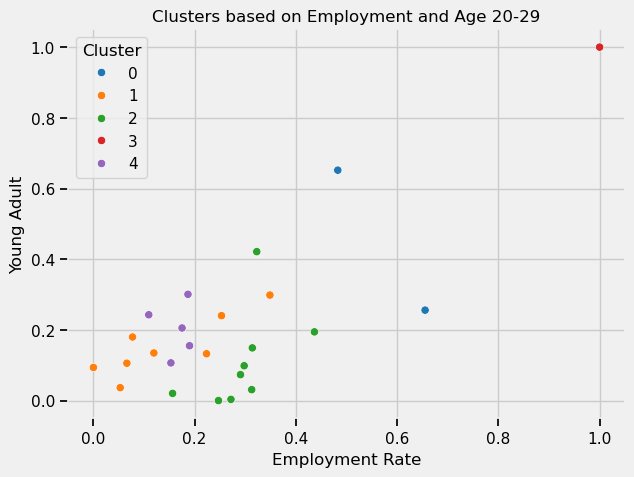

In [64]:
#Use only numeric columns 
num_cols = tdemograph_data_clean.select_dtypes(include=np.number).columns.tolist()
num_cols = [col for col in num_cols if col != 'Cluster']

#Visualize clusters with a plot, using 'Cluster' for hue

tdemograph_data_clean = tdemograph_data.dropna(axis=1, how='any') 



tdemograph_data_clean_scaled['Cluster'] = kmeans.labels_
tdemograph_data_clean_scaled['Cluster'] = tdemograph_data_clean_scaled['Cluster'].astype("category")
# Plot scatterplot with a defined x and y 
sns.scatterplot(
    data = tdemograph_data_clean_scaled, 
    x = 'Employed', 
    y = 'Young Adult', 
    hue = 'Cluster', 
    palette = 'tab10'
)
#Graph to verify clustering performance
plt.title("Clusters based on Employment and Age 20-29")
plt.xlabel("Employment Rate")
plt.ylabel("Young Adult")
plt.legend(title = "Cluster", loc='best')
plt.show()

In [66]:
tdemograph_data_clean_scaled

Grouping  Non-immigrants  Immigrants  No certificate, diploma or degree  \
0               0.288826    0.848265                           0.801413   
1               0.731784    0.429052                           0.334903   
2               1.000000    0.589202                           0.335688   
3               0.795468    0.012558                           0.154108   
4               0.468158    0.680735                           0.973574   
5               0.291756    0.714915                           0.426217   
6               0.235398    0.797126                           1.000000   
7               0.714593    0.331693                           0.287284   
8               0.625317    0.200155                           0.644165   
9               0.811584    0.569524                           0.000000   
10              0.598945    0.073537                           0.036107   
11              0.749170    0.220482                           0.087650   
12              0.533600    0.435396                           0.092883   
13              0.813049    0.000000                           0.310832   
14              0.524810    0.246116                           0.082679   
15              0.210588    0.478379                           0.267661   
16              0.102657    0.941611                           0.157771   
17              0.122778    1.000000                           0.068550   
18              0.827408    0.064863                           0.255887   
19              0.518461    0.477861                           0.467033   
20              0.287263    0.770456                           0.536368   
21              0.053526    0.884257                           0.535845   
22              0.000000    0.746375                           0.575615   
23              0.257961    0.593604                           0.430141   
24              0.324673    0.537157                           0.328100   

Grouping  High (secondary) school diploma or equivalency certificate  \
0                                                  0.983018            
1                                                  0.693555            
2                                                  0.723273            
3                                                  0.101505            
4                                                  1.000000            
5                                                  0.595137            
6                                                  0.983018            
7                                                  0.372443            
8                                                  0.295639            
9                                                  0.081822            
10                                                 0.000000            
11                                                 0.118873            
12                                                 0.380162            
13                                                 0.160556            
14                                                 0.011964            
15                                                 0.317252            
16                                                 0.309147            
17                                                 0.338865            
18                                                 0.316480            
19                                                 0.726746            
20                                                 0.883829            
21                                                 0.629101            
22                                                 0.583944            
23                                                 0.620996            
24                                                 0.695870            

Grouping  Postsecondary certificate, diploma or degree  Employed  Unemployed  \
0                                             0.123682  0.186720       0.617   
1               

In [68]:
#Inspect mean averages for each data point/cluster
cluster_means = tdemograph_data_clean_scaled.groupby('Cluster').mean()
cluster_means

Grouping  Non-immigrants  Immigrants  No certificate, diploma or degree  \
Cluster                                                                   
0               0.766800    0.512299                           0.214286   
1               0.170492    0.737037                           0.348738   
2               0.708949    0.175384                           0.243735   
3               0.811584    0.569524                           0.000000   
4               0.359621    0.714889                           0.755678   

Grouping  High (secondary) school diploma or equivalency certificate  \
Cluster                                                                
0                                                  0.551717            
1                                                  0.511289            
2                                                  0.230113            
3                                                  0.081822            
4                                                  0.915322            

Grouping  Postsecondary certificate, diploma or degree  Employed  Unemployed  \
Cluster                                                                        
0                                             0.662453  0.568991    0.843500   
1                                             0.244233  0.142583    0.333625   
2                                             0.377102  0.294358    0.264889   
3                                             1.000000  1.000000    0.720000   
4                                             0.119014  0.162804    0.575000   

Grouping  Average total income of households in 2020 ($)  \
Cluster                                                    
0                                               0.162473   
1                                               0.125629   
2                                               0.485342   
3                                               0.233645   
4                                               0.050036   

Grouping  Total visible minority population  Teenager  Young Adult  \
Cluster                                                              
0                                  0.460166  0.400150     0.453875   
1                                  0.768105  0.618260     0.152715   
2                                  0.133953  0.625562     0.110152   
3                                  0.669431  0.000000     1.000000   
4                                  0.812868  0.879581     0.202122   

Grouping  Middle Aged    Senior  Constructed from 2000 or before  \
Cluster                                                            
0            0.584584  0.637053                         0.838397   
1            0.138885  0.582957                         0.360335   
2            0.288308  0.538524                         0.786217   
3            1.000000  0.000000                         0.000000   
4            0.193586  0.591856                         0.612246   

Grouping  Constructed from 2000 or after  Lower Class  Middle Class  \
Cluster                                                               
0                               0.425501     0.717418      0.645463   
1                               0.096371     0.197422      0.162381   
2                               0.089373     0.293015      0.223448   
3                               1.000000     0.660720      1.000000   
4                               0.027458     0.243363      0.220049   

Grouping  High Class  
Cluster               
0           0.645822  
1           0.211652  
2           0.790241  
3           0.964105  
4           0.097813

### Plot each feature in each cluster

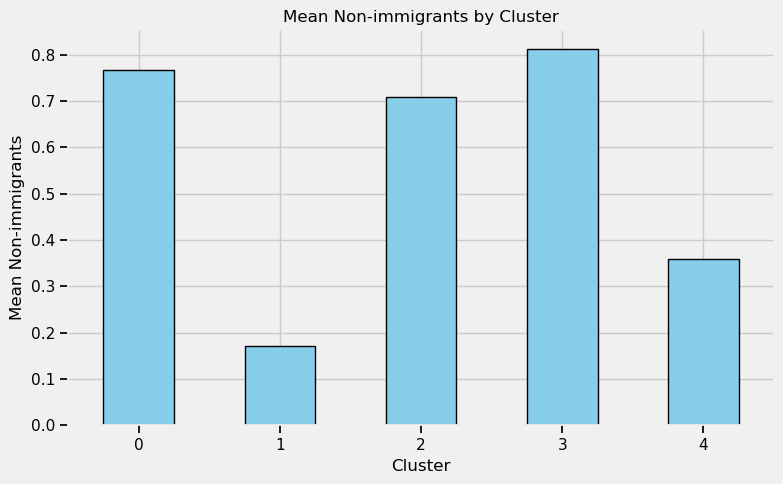

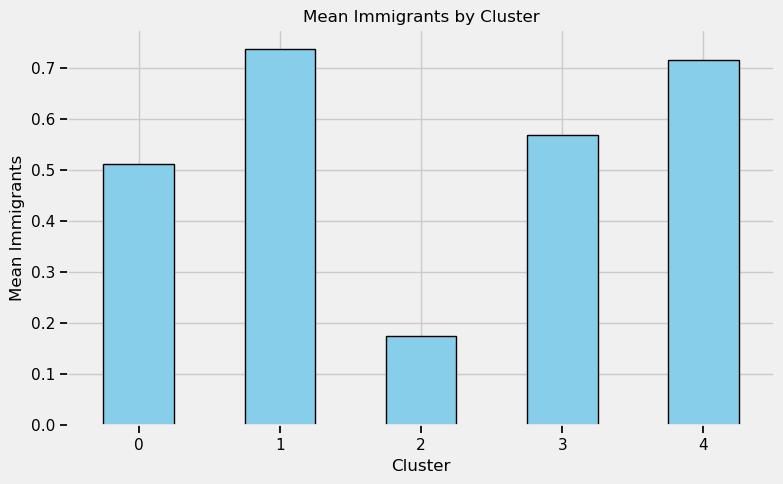

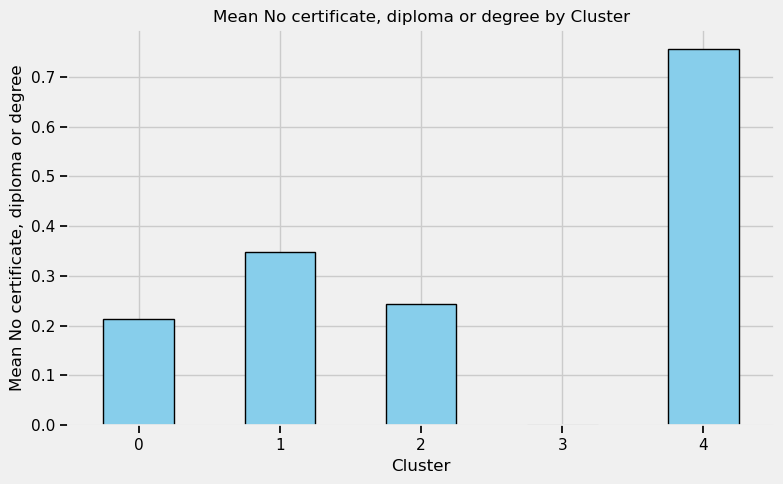

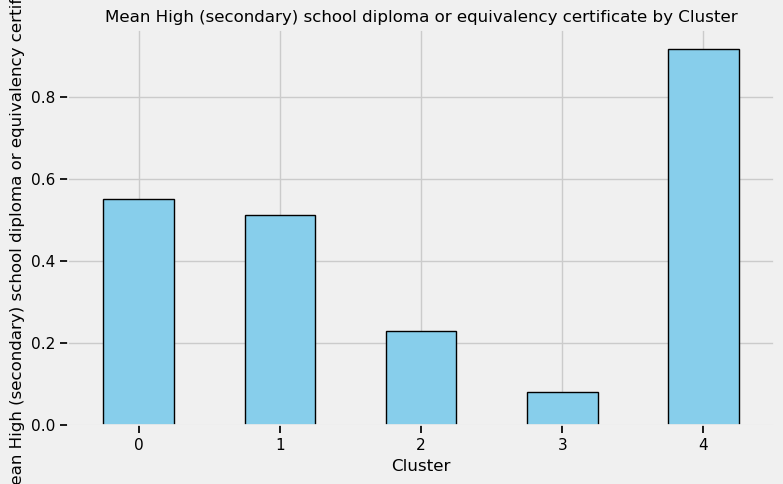

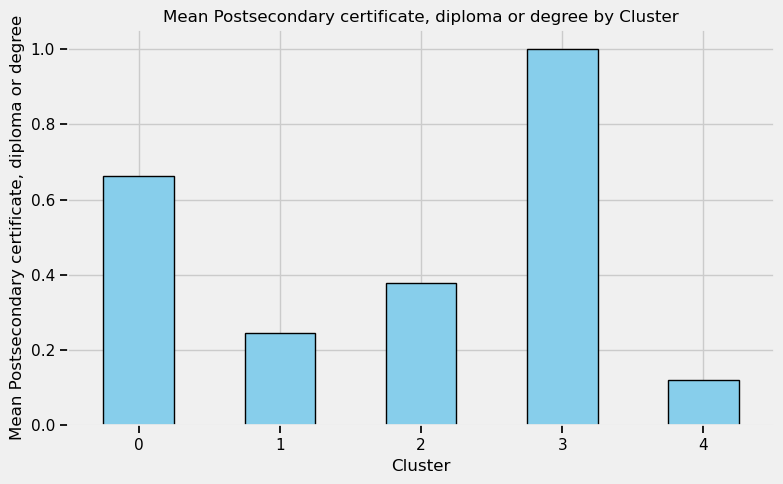

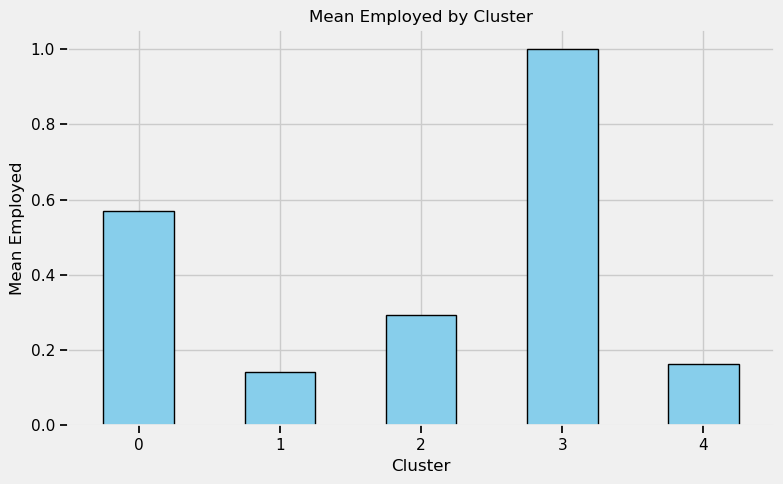

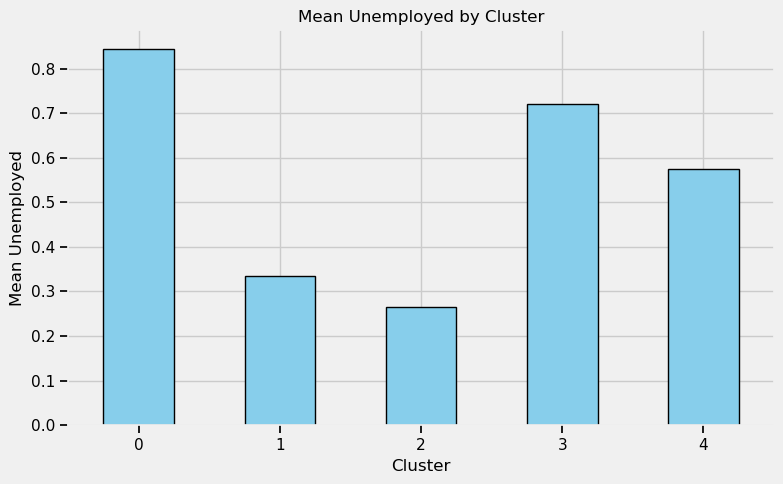

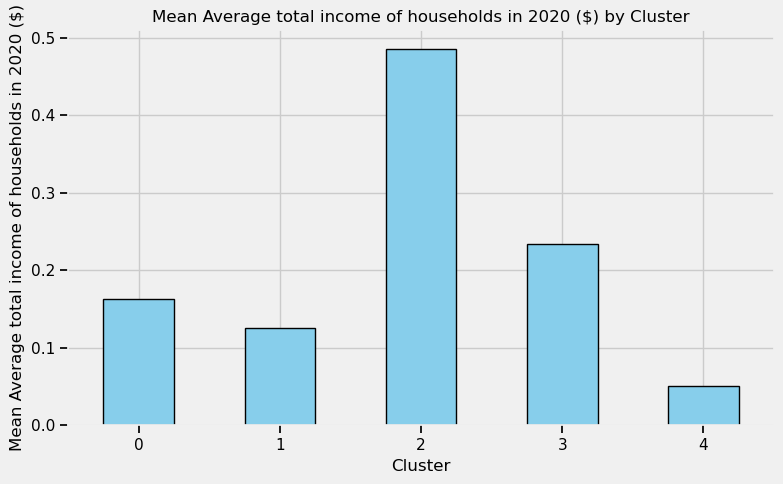

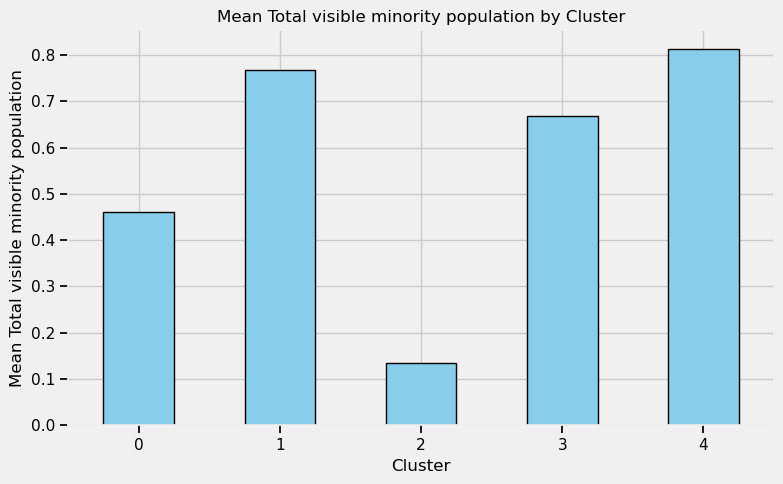

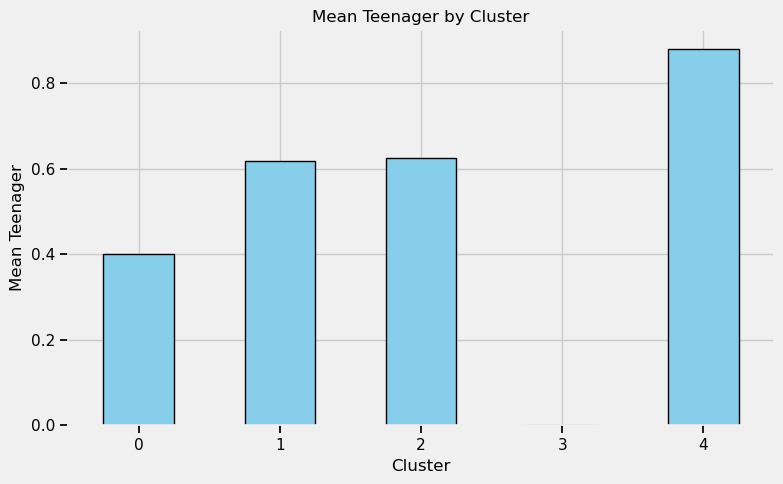

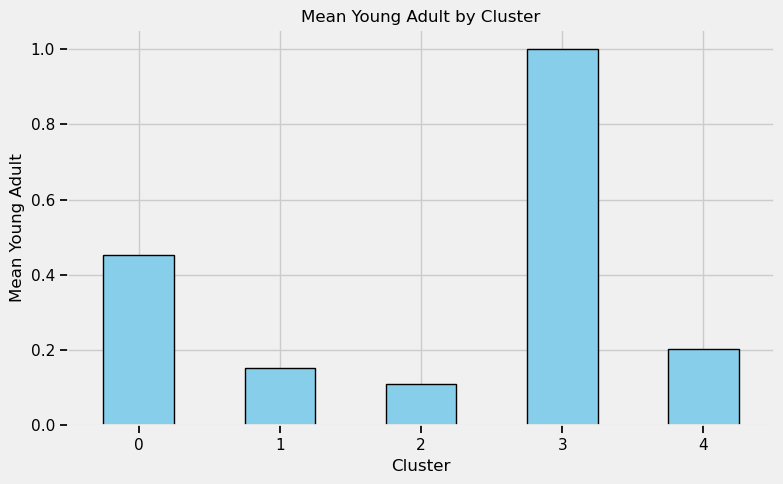

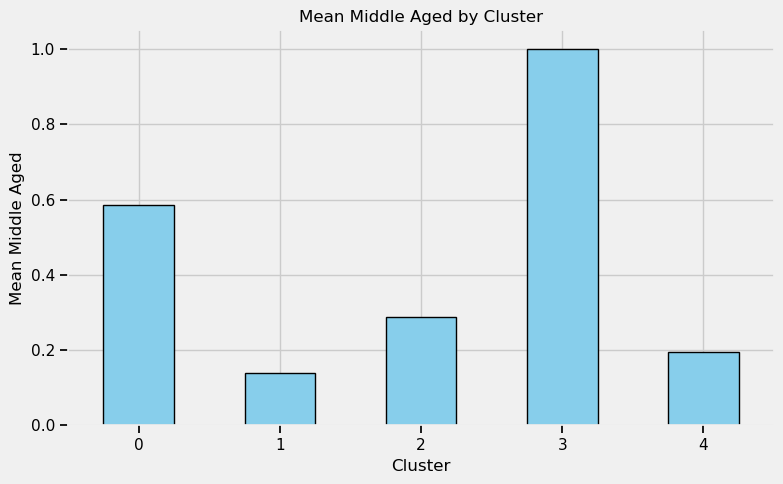

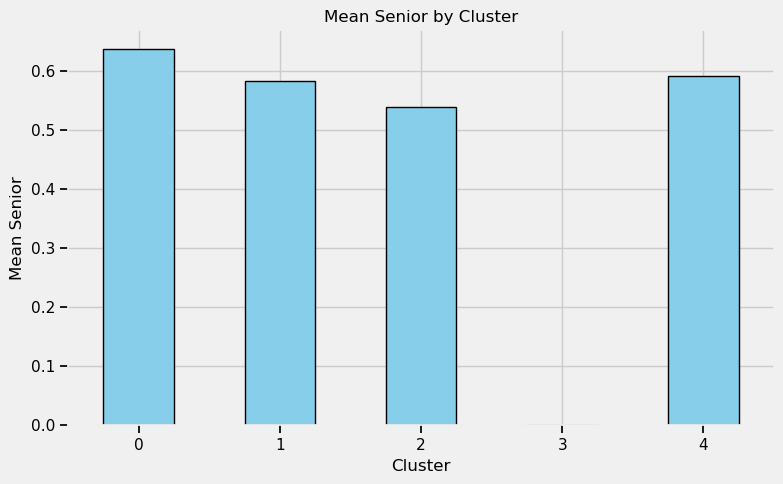

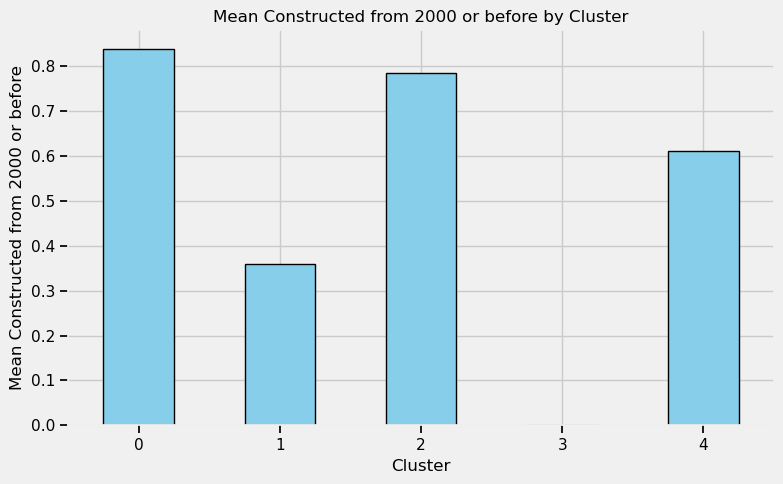

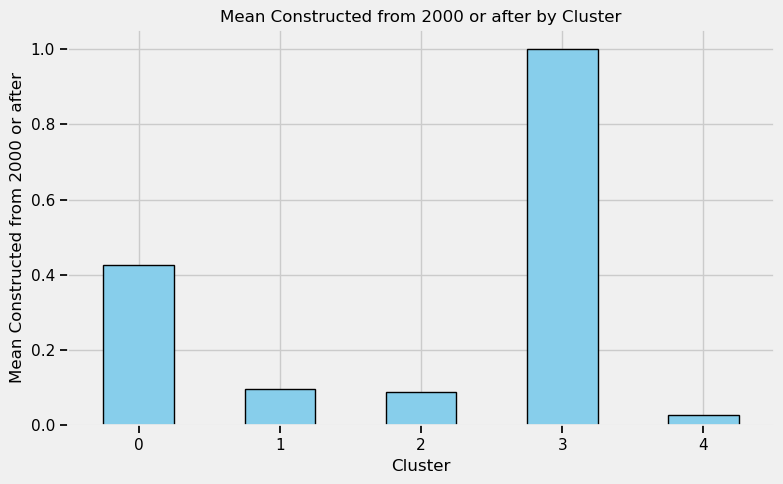

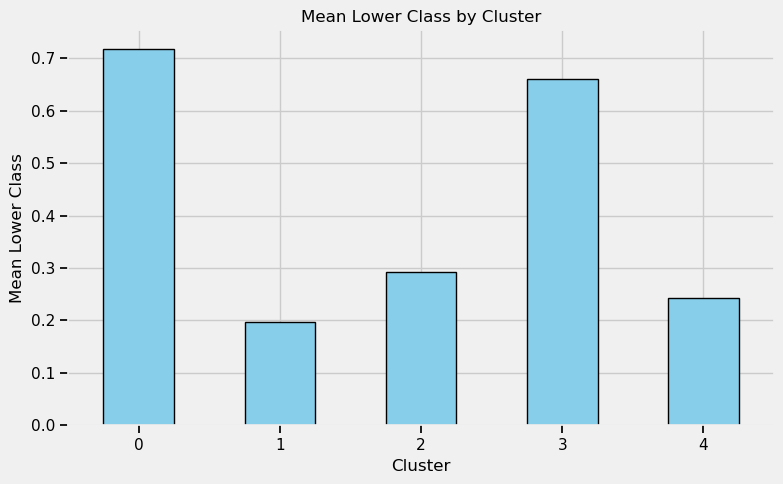

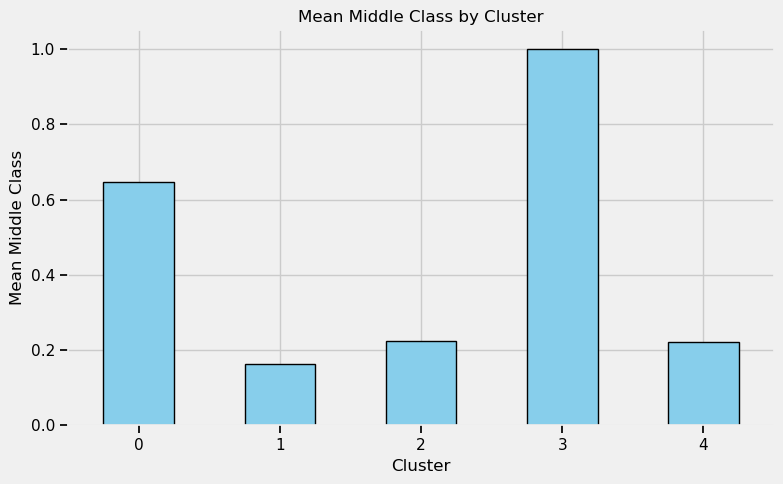

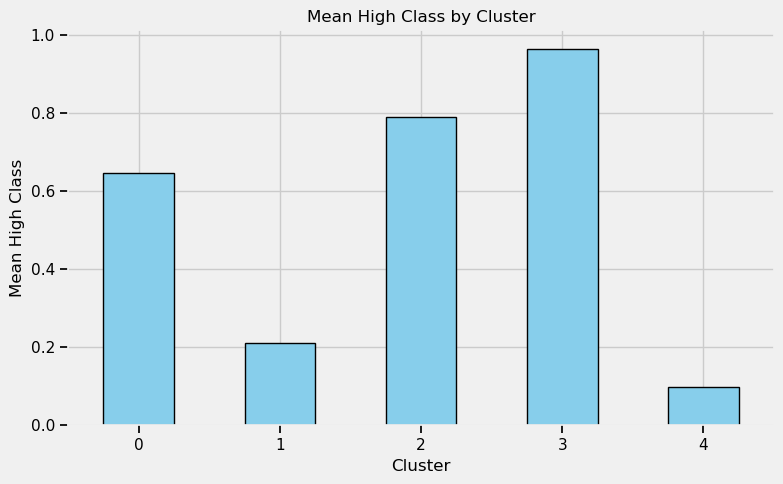

In [70]:
#Plotting each feature showing the mean for each cluster for that feature
for feature in cluster_means.columns:
    # Plotting
    cluster_means[feature].plot(
        kind='bar',
        figsize=(8, 5),
        color='skyblue',
        edgecolor='black'
    ) 
    plt.xlabel('Cluster')
    plt.ylabel(f'Mean {feature}')
    plt.title(f'Mean {feature} by Cluster')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

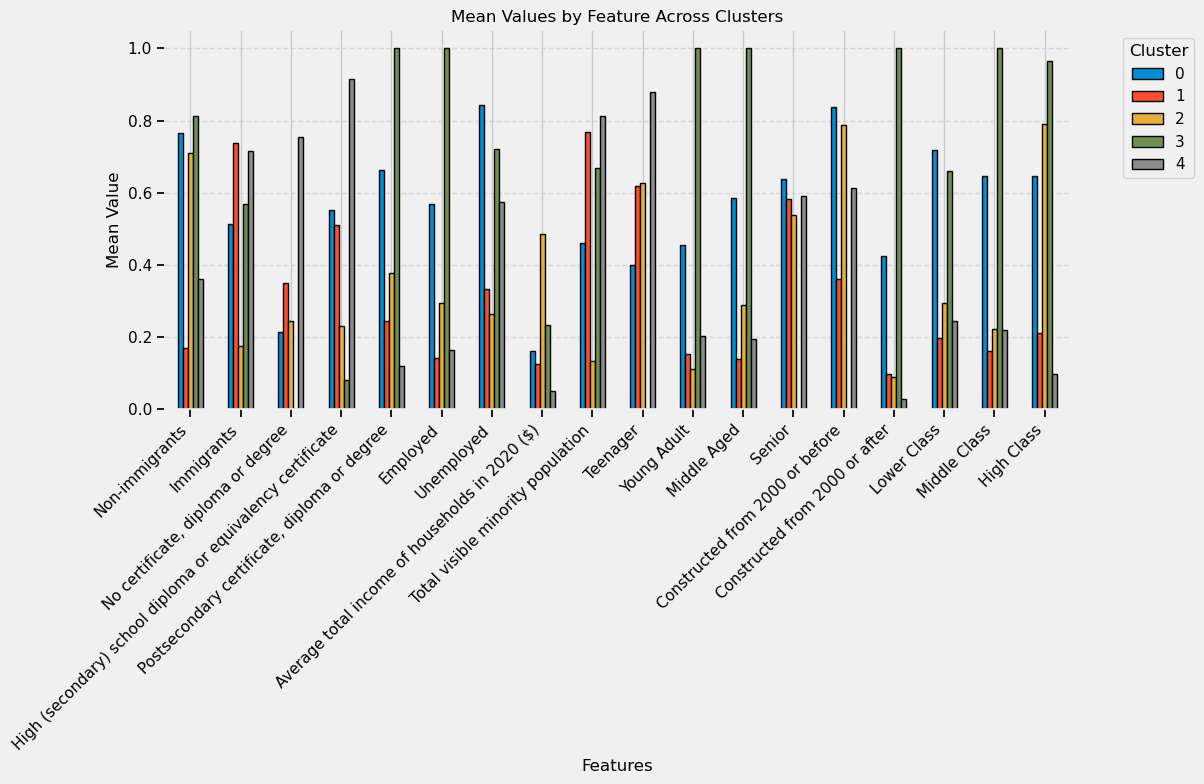

In [71]:
#Transpose cluster_means to make features the x-axis and clusters the categories
cluster_means_t = cluster_means.T
#Plot a grouped bar chart
cluster_means_t.plot(
    kind='bar',
    figsize=(12, 8),
    edgecolor='black'
)

plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.title('Mean Values by Feature Across Clusters')
plt.xticks(rotation = 45, ha = 'right')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc = 'upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [73]:
tdemograph_data_clean_scaled.columns

Index(['Non-immigrants', 'Immigrants', 'No certificate, diploma or degree',
       'High (secondary) school diploma or equivalency certificate',
       'Postsecondary certificate, diploma or degree', 'Employed',
       'Unemployed', 'Average total income of households in 2020 ($)',
       'Total visible minority population', 'Teenager', 'Young Adult',
       'Middle Aged', 'Senior', 'Constructed from 2000 or before',
       'Constructed from 2000 or after', 'Lower Class', 'Middle Class',
       'High Class', 'Cluster'],
      dtype='object', name='Grouping')

In [74]:
tdemograph_data_clean_scaled['Ward #'] = range(1, 26)
tdemograph_data_clean_scaled['Ward #'].astype(int)
#tdemograph_data_clean_scaled

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
23    24
24    25
Name: Ward #, dtype: int32

In [75]:
#tdemograph_data_clean_scaled.info()

In [76]:
ward_collision['Ward #'] = ward_collision['Ward #'].astype(int)
ward_collision.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ward #           25 non-null     int32  
 1   Ward Name        25 non-null     object 
 2   Bike Collisions  25 non-null     int64  
 3   Avg Latitude     25 non-null     float64
 4   Avg Longitude    25 non-null     float64
 5   Area (sqkm)      25 non-null     float64
dtypes: float64(3), int32(1), int64(1), object(1)
memory usage: 1.2+ KB


In [77]:
#Merge the collision data with the demographic data, using the 'Ward #' column for merging
merged_df = tdemograph_data_clean_scaled.merge(
    ward_collision,
    on = 'Ward #',
    how = 'left')

merged_df

Non-immigrants  Immigrants  No certificate, diploma or degree  \
0         0.288826    0.848265                           0.801413   
1         0.731784    0.429052                           0.334903   
2         1.000000    0.589202                           0.335688   
3         0.795468    0.012558                           0.154108   
4         0.468158    0.680735                           0.973574   
5         0.291756    0.714915                           0.426217   
6         0.235398    0.797126                           1.000000   
7         0.714593    0.331693                           0.287284   
8         0.625317    0.200155                           0.644165   
9         0.811584    0.569524                           0.000000   
10        0.598945    0.073537                           0.036107   
11        0.749170    0.220482                           0.087650   
12        0.533600    0.435396                           0.092883   
13        0.813049    0.000000                           0.310832   
14        0.524810    0.246116                           0.082679   
15        0.210588    0.478379                           0.267661   
16        0.102657    0.941611                           0.157771   
17        0.122778    1.000000                           0.068550   
18        0.827408    0.064863                           0.255887   
19        0.518461    0.477861                           0.467033   
20        0.287263    0.770456                           0.536368   
21        0.053526    0.884257                           0.535845   
22        0.000000    0.746375                           0.575615   
23        0.257961    0.593604                           0.430141   
24        0.324673    0.537157                           0.328100   

    High (secondary) school diploma or equivalency certificate  \
0                                            0.983018            
1                                            0.693555            
2                                            0.723273            
3                                            0.101505            
4                                            1.000000            
5                                            0.595137            
6                                            0.983018            
7                                            0.372443            
8                                            0.295639            
9                                            0.081822            
10                                           0.000000            
11                                           0.118873            
12                                           0.380162            
13                                           0.160556            
14                                           0.011964            
15                                           0.317252            
16                                           0.309147            
17                                           0.338865            
18                                           0.316480            
19                                           0.726746            
20                                           0.883829            
21                                           0.629101            
22                                           0.583944            
23                                           0.620996            
24                                           0.695870            

    Postsecondary certificate, diploma or degree  Employed  Unemployed  \
0                                       0.123682  0.186720       0.617   
1                                       0.371123  0.290484       0.297   
2                                       0.699287  0.655230       0.687   
3                                       0.385468  0.312679       0.355   
4                                       0.078396  0.189864       0.608   
5                                       0.238136

In [78]:
#Checking the datatypes again for the dataframe
#merged_df.info()

In [79]:
#We now have wards_data and merged_df
#To spatially map the wards and the clusters they are in, instead of creating a function, it can be easier to create a new dataframe that contains the data I want
cluster_df = merged_df[['Ward #', 'Ward Name', 'Cluster']]
cluster_df['AREA_NAME'] = cluster_df['Ward Name']
wards = gpd.read_file('../Ward Data/WARD_WGS84.shp')
wards.crs

DataSourceError: ../Ward Data/WARD_WGS84.shp: No such file or directory

In [ ]:
wards.to_crs(epsg = 4326)

In [ ]:
map_df = wards.merge(cluster_df[['Ward #', 'AREA_NAME', 'Cluster']], on = 'AREA_NAME', how = 'left') #Merge relevant dataframes
clustercolor = {0: 'blue', 1: 'purple', 2: 'red', 3: 'green', 4: 'orange'} #Create a dictionary of colors to map different clusters to
map_df['color'] = map_df['Cluster'].map(clustercolor) #Map it

#Create a map of Toronto
cluster_map = folium.Map(location = [43.6426, -79.3871], 
                               tiles = 'cartodbpositron', 
                               zoom_start = 10)

# Overlay the ward boundaries with the color of the clusters
folium.GeoJson(
    map_df,
    style_function = lambda feature: { #Set general map properties
        'fillColor': feature['properties']['color'],
        'color': 'black',   #Border color
        'weight': 1,        #Border weight
        'fillOpacity': 0.6  #Opacity of map
    },
    tooltip = folium.features.GeoJsonTooltip(fields=['Ward #', 'Cluster']) #Create a tooltip to show additional info when hovering over map
).add_to(cluster_map)

cluster_map

In [ ]:
#Describe the mean value of cluster-specific data points for a feature 
num_columns = cluster_means.select_dtypes(include = ['float64', 'int64']).columns

for feature in num_columns:
    #Calculate feature composition percentages
    feat_percent = cluster_means[feature] / cluster_means[feature].sum() * 100
    
    #Plot the pie chart
    feat_percent.plot(
        kind = 'pie',
        autopct = '%1.1f%%',
        figsize =( 6, 6),
        startangle = 90,
        cmap = 'tab20',
        title = f"The Cluster Contribution to {feature}"
    )
    plt.ylabel('') #Don't show a y-axis label
    plt.show()

In [ ]:
#mcluster_percent being merged cluster percentage 
mcluster_percent = merged_df.groupby('Cluster').sum() #Grouping data by clusters, then summing each of the features for those clusters 

mcluster_percent = mcluster_percent.select_dtypes(include = ['float64', 'int64']) #Selecting numerical data types

normalized_data = mcluster_percent.div(mcluster_percent.sum(axis = 0), axis = 1) * 100 #Dividing by the total sum of each feature across all clusters

max_contributors = normalized_data.idxmax(axis = 0) #Finding the cluster corresponding to the maximum value for each feature

In [ ]:
print(max_contributors)

In [ ]:
normalized_data.T.plot(kind='bar', figsize=(12, 6), stacked=True)
plt.title("Cluster Contributions to Features")
plt.ylabel("Percentage Contribution")
plt.show()

In [ ]:
merged_df = merged_df.select_dtypes(include = ['float64', 'int64']) #Selecting numerical data types
correlation = merged_df.corr() 
print(correlation['Bike Collisions'].sort_values(ascending=False))
# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, annot_kws={"size": 10})
# plt.title("Correlation Heatmap")
# plt.show()

In [ ]:
#print(normalized_data[normalized_data['Cluster'] == 2]['Bike Collisions'].sum())

In [ ]:
#normalized_data['Collision/sqkm'] = normalized_data['Bike Collisions'] / normalized_data['Area (sqkm)']
num_columns = normalized_data.select_dtypes(include = ['float64', 'int64']).columns
for feature in num_columns:
    # Calculate percentages for the feature
    feature_percentage = normalized_data[feature] / normalized_data[feature].sum() * 100
    
    # Plot the pie chart
    feature_percentage.plot(
        kind = 'pie',
        autopct = '%1.1f%%',
        figsize =( 6, 6),
        startangle = 90,
        cmap = 'tab20',
        title = f"The Cluster Contribution to {feature}"
    )
    plt.ylabel('')  # Remove y-axis label
    plt.show()

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(normalized_data, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Percentage Contribution of Clusters to Features")
plt.show()

In [ ]:
#Based on the above information, it seems that cluster 2 experiences the highest bicycle collision rate with certain features like societal class, age, employment, and neighbourhood age showing strong positive correlations
#So I will focus on those (and maybe add another one as well)
#So I begin to show pie charts of those and any other types of graphs of those in relation, and also even though it did not have the highest number of wards in that cluster by about 20% of the data, it still 'outperformed' the other cluster that did, cluster 1, in those relevant features! 

In [ ]:
showncluster = 2

#Filter the data to only show the contribution of features for the cluster 2
cluster_data = normalized_data.loc[showncluster, :].to_frame().T  

plt.figure(figsize=(20, 8))
sns.heatmap(cluster_data, annot=True, cmap='coolwarm', fmt=".1f")
plt.title(f"Percentage Contribution of Features to Cluster {showncluster}")
plt.show()

### Looking at Features More in Depth: Violin Plots

In [ ]:
cluster_2_data = tdemograph_data_clean_scaled[tdemograph_data_clean_scaled['Cluster'] == 2]

# Create a violin plot for income distribution in Cluster 2
plt.figure(figsize=(10, 6))
sns.violinplot(
    data = cluster_2_data,
    y='Average total income of households in 2020 ($)',  
    palette='muted')

plt.title('Average Total Income Distribution for Cluster 2')
plt.ylabel('Income')
plt.xlabel('Cluster 2')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.0,1.4)
plt.show()

In [ ]:
cluster_2_data = tdemograph_data_clean_scaled[tdemograph_data_clean_scaled['Cluster'] == 2]

# Create a violin plot for income distribution in Cluster 2
plt.figure(figsize=(10, 6))
sns.violinplot(
    data = cluster_2_data,
    y = 'Lower Class',  
    palette = 'muted')

plt.title('Lower Class Distribution for Cluster 2')
plt.ylabel('Perc')
plt.xlabel('Cluster 2')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.0,1.4)
plt.show()

In [ ]:
cluster_2_data = tdemograph_data_clean_scaled[tdemograph_data_clean_scaled['Cluster'] == 2]

#Sum the counts
employed_count = cluster_2_data['Employed'].sum() 
unemployed_count = cluster_2_data['Unemployed'].sum() 

# Create data for the pie chart
labels = ['Employed', 'Unemployed']
sizes = [employed_count, unemployed_count]
colors = ['Blue', 'Red']

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors, 
    explode=(0.1, 0)  # Emphasize employed (optional)
)
plt.title('Employment Status in Cluster 2')
plt.show()